In [1]:
from keras.models import load_model
import cv2
import numpy as np
import csv
import glob
import keras
from sklearn.metrics import accuracy_score
from keras.models import model_from_json
import matplotlib.pyplot as plt
import operator
import urllib.request

#from tensorflow.contrib.gan.python.eval import preprocess_image

Using TensorFlow backend.
/home/johnson/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/johnson/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/johnson/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/johnson/anaconda3/lib/python3.6/site-packages/t

In [2]:
IMG_SIZE = 48

In [3]:
#loaddata
def loadtest():
    X = []
    Y = []
    imagOrig=[]

    path = glob.glob('test/*/*.jpg')
    for img in path:
        #print(img)
        image = cv2.imread(img)
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        image = cv2.resize(draw, (IMG_SIZE, IMG_SIZE))
        c = int(img.replace('\\','/').split('/', -1)[-2])
            
        y = np.zeros(6)
        y[c] = 1.
        X.append(image)
        Y.append(y)
        imagOrig.append(img)
    #print(X)
    X = np.array(X, dtype=np.uint8)
    Y = np.array(Y,dtype=np.float32)
    return X, Y, imagOrig


In [4]:
##################################################################################################################
# Function to load classes names
##################################################################################################################
# load classes and indices
def load_class():
    classes = {}
    with open('class.csv', 'r') as csvfile:
        reader_csv = csv.reader(csvfile)
        #next(reader_csv)

        for line in reader_csv:
            id = str(line[0])
            label = str(line[1])
            classes[id] = label
            #print(str(id) + ':' + str(label))
    return classes

In [5]:
classe=load_class()
print(classe)

{'0': 'angry', '1': 'disgust', '2': 'fear', '3': 'happy', '4': 'sad', '5': 'surprise'}


In [6]:
##################################################################################################################
# Function to load the saved model
##################################################################################################################

def load_keras_model(filename):
    # load json and create model
    json_file = open('newmodel/'+filename+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights('newmodel/model_weights'+".h5")
    #model.load_weights('/home/jobee16/Downloads/GTSRB/model-keras_weights'+".h5")

    return model

filename_to_load='modelfacial'
model = load_keras_model(filename_to_load)

In [44]:
##################################################################################################################
# compile  the loaded model
##################################################################################################################
#sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adam=keras.optimizers.Adam(lr=1e-6)
sgd = keras.optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.compile(optimizer=sgd, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


In [10]:
#Evaluation du modele
X_test,Y_test, imagOrig= loadtest2()

scores = model.evaluate(X_test, Y_test, verbose=0)
print("Model performance (%s): %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("Model error rate : %.2f%%" % (100-scores[1]*100))

Model performance (acc): 99.25%
Model error rate : 0.75%


In [46]:
#print(X_test[1])
print(imagOrig[2])
print(Y_test[5])

test/0/User.1.47.jpg
[1. 0. 0. 0. 0. 0.]


In [47]:
##################################################################################################################
# Function to predict take one image
##################################################################################################################

# Prediction
#img0 = cv2.imread('/home/jobee16/Desktop/for_test/t.jpg')

def predict_image(image):
    draw = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(draw, (IMG_SIZE, IMG_SIZE))
    img = np.reshape(img, [1, IMG_SIZE, IMG_SIZE, 3])
    img_class = model.predict(img)
    prediction = img_class[0]

    listPrd=[]
    for i in prediction:
        listPrd.append(i)
        index, value = max(enumerate(listPrd), key=operator.itemgetter(1))
    print(index, value)
    print(prediction)

    # show image plot
    plt.imshow(draw)
    plt.title("Classe: %s, predict: %.2f%%\n" % (load_class().get(str(index)), value*100), fontsize=13)
    plt.show()

2 0.93569356
[0.00192025 0.01830662 0.93569356 0.01903091 0.01609443 0.00895423]


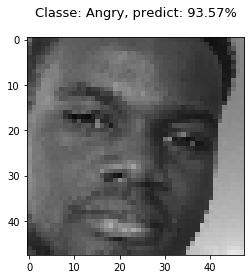

In [60]:
predict_image(X_test[81])

In [61]:
##################################################################################################
# Function to predict by decoding vector prediction
##################################################################################################
#for x in X_test:
prediction= model.predict(X_test[:len(X_test)])

def prediction_evaluation(vect):
    count=0; nbr=0
    for i in vect:
        nbr=nbr+1
        print("class predicted: %s, precent: %.2f%%" % (np.argmax(i), max(i)*100))
        print("True Class: %s " % (np.argmax(Y_test[nbr-1])))
        if np.argmax(i)==np.argmax(Y_test[nbr-1]):
            count=count+1
    evaluation= (count/X_test.shape[0])*100
    print(nbr)
    print("Preformance: %s%% " % (evaluation))

    return evaluation

class predicted: 0, precent: 94.35%
True Class: 0 
class predicted: 0, precent: 93.58%
True Class: 0 
class predicted: 0, precent: 88.97%
True Class: 0 
class predicted: 0, precent: 95.35%
True Class: 0 
class predicted: 0, precent: 94.25%
True Class: 0 
class predicted: 0, precent: 72.19%
True Class: 0 
class predicted: 0, precent: 94.06%
True Class: 0 
class predicted: 0, precent: 93.16%
True Class: 0 
class predicted: 0, precent: 95.01%
True Class: 0 
class predicted: 0, precent: 96.61%
True Class: 0 
class predicted: 0, precent: 94.44%
True Class: 0 
class predicted: 0, precent: 96.36%
True Class: 0 
class predicted: 0, precent: 95.46%
True Class: 0 
class predicted: 0, precent: 92.06%
True Class: 0 
class predicted: 5, precent: 59.07%
True Class: 0 
class predicted: 0, precent: 22.03%
True Class: 0 
class predicted: 0, precent: 91.34%
True Class: 0 
class predicted: 0, precent: 95.00%
True Class: 0 
class predicted: 5, precent: 72.30%
True Class: 0 
class predicted: 0, precent: 95

2 0.92051214
[0.00201215 0.03038589 0.92051214 0.02227319 0.01912008 0.00569651]


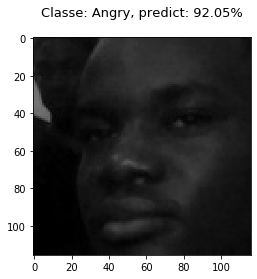

In [62]:
prediction_evaluation(prediction)
#test repository file test
img0 = cv2.imread('/home/johnson/envs/DeeplearningW/test/2/User.2.6.jpg')
predict_image(img0)

In [ ]:
from keras.preprocessing import image

#url='http://192.168.0.132:8080/shot.jpg'
cam=cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX
face_haar_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')

while(True):
    #imgResp=urllib.request.urlopen(url);
    #imgNp=np.array(bytearray(imgResp.read()),dtype=np.uint8)
    #imga=cv2.imdecode(imgNp,-1)
    ret, test_img = cam.read()  # captures frame and returns boolean value and captured image
    if not ret:
        pass
    gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.3, 4)
    
    for (x, y, w, h) in faces_detected:
        cv2.rectangle(test_img, (x, y), (x + w, y + h), (255, 0, 0), thickness=2)
        #cv2.line(test_img, (x, y), (x+50, y), (0, 0, 255), 1)
        #cv2.line(test_img, (x, y), (x, y+50), (0, 0, 255), 1)
        roi_gray = gray_img[y:y + w, x:x + h]
        image = cv2.resize(roi_gray, (IMG_SIZE, IMG_SIZE))
        image = np.array(image, dtype=np.uint8)
        draw = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img = np.reshape(draw, [1, IMG_SIZE, IMG_SIZE, 3])
        img_class = model.predict(img)

        cv2.putText(test_img,(load_class().get(str(np.argmax(img_class[0], axis=0)))),(x,y-10),font,1,(0,255,255),2)
    #ims = cv2.resize(test_img, (760, 440))
    ims = cv2.resize(test_img, (1080, 600))
    cv2.imshow("Face Detection",ims);
    if(cv2.waitKey(1)==ord('q')):
        break;
#cam.release()
cv2.destroyAllWindows()

In [ ]:
from keras.preprocessing import image

url='http://192.168.43.1:8080/shot.jpg'
#cam=cv2.VideoCapture(0)
#font = cv2.FONT_HERSHEY_SIMPLEX
face_haar_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')

while(True):
    imgResp=urllib.request.urlopen(url);
    imgNp=np.array(bytearray(imgResp.read()),dtype=np.uint8)
    imga=cv2.imdecode(imgNp,-1)
    #ret, test_img = cam.read()  # captures frame and returns boolean value and captured image
    #if not ret:
    #    pass
    gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.3, 4)
    
    for (x, y, w, h) in faces_detected:
        cv2.rectangle(imga, (x, y), (x + w, y + h), (255, 0, 0), thickness=2)
        #cv2.line(test_img, (x, y), (x+50, y), (0, 0, 255), 1)
        #cv2.line(test_img, (x, y), (x, y+50), (0, 0, 255), 1)
        roi_gray = gray_img[y:y + w, x:x + h]
        image = cv2.resize(roi_gray, (IMG_SIZE, IMG_SIZE))
        image = np.array(image, dtype=np.uint8)
        draw = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img = np.reshape(draw, [1, IMG_SIZE, IMG_SIZE, 3])
        img_class = model.predict(img)

        cv2.putText(test_img,(load_class().get(str(np.argmax(img_class[0], axis=0)))),(x,y-10),font,1,(0,255,255),2)
    #ims = cv2.resize(test_img, (760, 440))
    ims = cv2.resize(test_img, (1080, 600))
    cv2.imshow("Face Detection",ims);
    if(cv2.waitKey(1)==ord('q')):
        break;
#cam.release()
cv2.destroyAllWindows()